In [52]:
import pandas as pd

# Step 1: Load the dataset
file_path = r'C:\Users\satyarth\Downloads\set_1_converted.csv'  # your local path
df = pd.read_csv(file_path)

# Step 2: Ensure Material is string type
df['Material'] = df['Material'].astype(str)

# Step 3: Filter for Material F360010CP
material_F360010CP = df[df['Material'].str.strip() == 'F360010CP']

# Step 4: Reshape to Time Series (Month → Demand)
# Drop unnecessary columns
drop_cols = ['Material', 'Description', 'Range', 'Subcat']
material_F360010CP_ts = material_F360010CP.drop(columns=drop_cols)

# Step 5: Transpose (flip rows and columns)
material_F360010CP_ts = material_F360010CP_ts.transpose()

# Step 6: Clean the index (remove "Actual" and extra spaces)
material_F360010CP_ts.index = material_F360010CP_ts.index.str.replace('Actual', '', regex=False)
material_F360010CP_ts.index = material_F360010CP_ts.index.str.strip()

# Step 7: Reset index and rename columns
material_F360010CP_ts = material_F360010CP_ts.reset_index()
material_F360010CP_ts.columns = ['Month', 'Demand']

# Step 8: Convert 'Month' into datetime

material_F360010CP_ts['Month'] = pd.to_datetime(material_F360010CP_ts['Month'], format='%b %y')
material_F360010CP_ts['Month'] = material_F360010CP_ts['Month'] + pd.offsets.MonthEnd(0)

# Step 9: Final time series ready
print(material_F360010CP_ts)

# (Optional) Set Month as index if needed
# material_F360010CP_ts = material_F360010CP_ts.set_index('Month')


        Month  Demand
0  2021-04-30     925
1  2021-05-31     130
2  2021-06-30    1064
3  2021-07-31     620
4  2021-08-31    1193
5  2021-09-30     723
6  2021-10-31    1074
7  2021-11-30     845
8  2021-12-31     858
9  2022-01-31     924
10 2022-02-28     552
11 2022-03-31     813
12 2022-04-30    1109
13 2022-05-31     941
14 2022-06-30     506
15 2022-07-31     740
16 2022-08-31     717
17 2022-09-30     531
18 2022-10-31     817
19 2022-11-30     762
20 2022-12-31     485
21 2023-01-31     824
22 2023-02-28     738
23 2023-03-31     652
24 2023-04-30     529
25 2023-05-31     170
26 2023-06-30     611
27 2023-07-31     633
28 2023-08-31     622
29 2023-09-30     473
30 2023-10-31     628
31 2023-11-30     445


🔍 Missing Values:
 Demand    0
dtype: int64


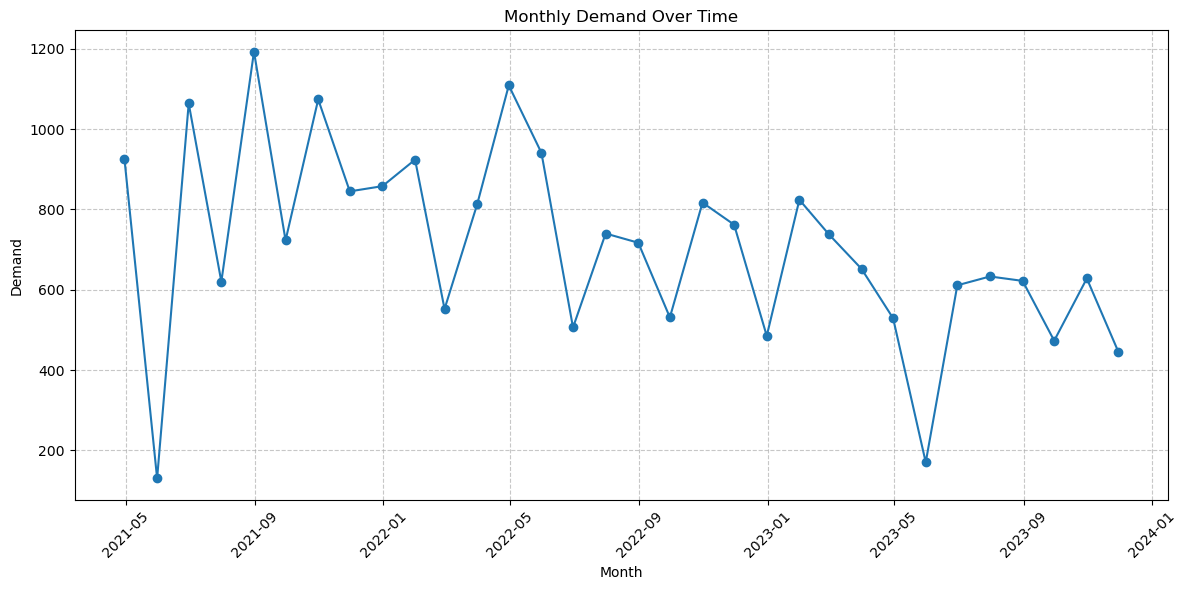


🚨 Outliers Detected: 0 entries
Empty DataFrame
Columns: [Demand]
Index: []


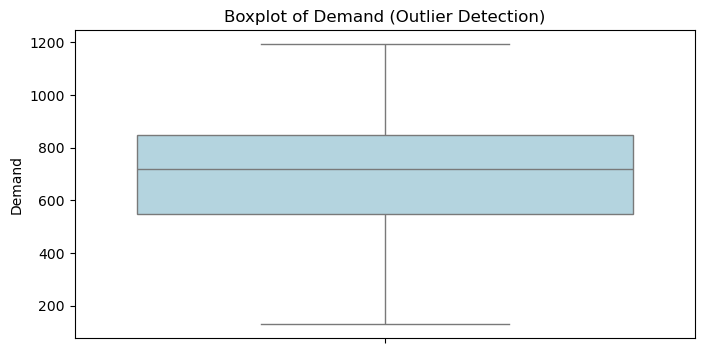

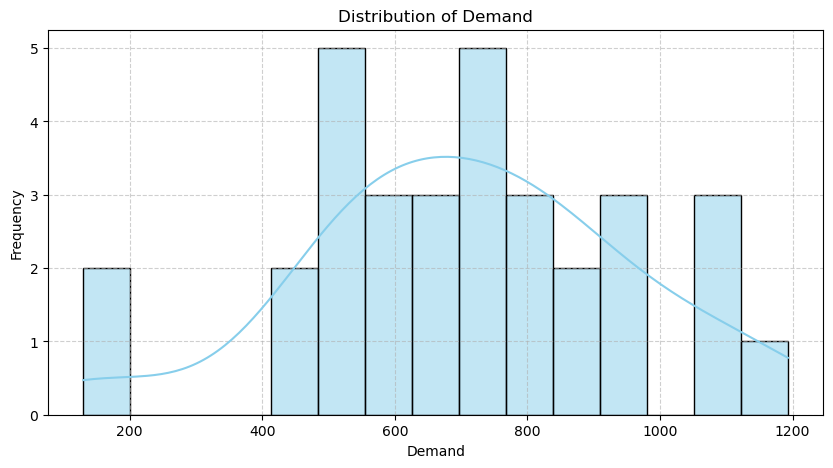

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Month as datetime index for time series analysis
material_F360010CP_ts = material_F360010CP_ts.set_index('Month')

# ----- 1. Missing Values -----
missing_values = material_F360010CP_ts.isnull().sum()
print("🔍 Missing Values:\n", missing_values)

# ----- 4. Demand Over Time -----
plt.figure(figsize=(12, 6))
plt.plot(material_F360010CP_ts.index, material_F360010CP_ts['Demand'], marker='o', linestyle='-')
plt.title("Monthly Demand Over Time")
plt.xlabel("Month")
plt.ylabel("Demand")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ----- 2. Outlier Detection (IQR Method) -----
Q1 = material_F360010CP_ts['Demand'].quantile(0.25)
Q3 = material_F360010CP_ts['Demand'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = material_F360010CP_ts[(material_F360010CP_ts['Demand'] < lower_bound) |
                                 (material_F360010CP_ts['Demand'] > upper_bound)]

print(f"\n🚨 Outliers Detected: {len(outliers)} entries")
print(outliers)

# Visualize with boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=material_F360010CP_ts, y='Demand', color='lightblue')
plt.title("Boxplot of Demand (Outlier Detection)")
plt.show()

# ----- 3. Demand Distribution (Histogram) -----
plt.figure(figsize=(10, 5))
sns.histplot(material_F360010CP_ts['Demand'], bins=15, kde=True, color='skyblue')
plt.title("Distribution of Demand")
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()




<Figure size 1400x1000 with 0 Axes>

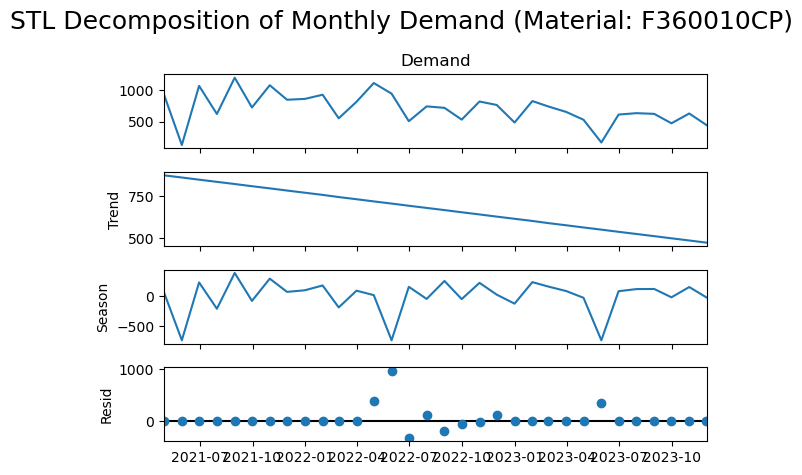

In [54]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Assuming you already have this from earlier EDA:
# material_F360010CP_ts = material_F360010CP_ts.set_index('Month')

# Optional safety check: make sure Demand column is float (for STL)
material_F360010CP_ts['Demand'] = pd.to_numeric(material_F360010CP_ts['Demand'], errors='coerce')

# Step 1: Perform STL Decomposition
stl = STL(material_F360010CP_ts['Demand'], period=12, robust=True)  # Monthly data with yearly seasonality
result = stl.fit()

# Step 2: Plot the decomposition
plt.figure(figsize=(14, 10))
result.plot()
plt.suptitle('STL Decomposition of Monthly Demand (Material: F360010CP)', fontsize=18)
plt.tight_layout()
plt.show()




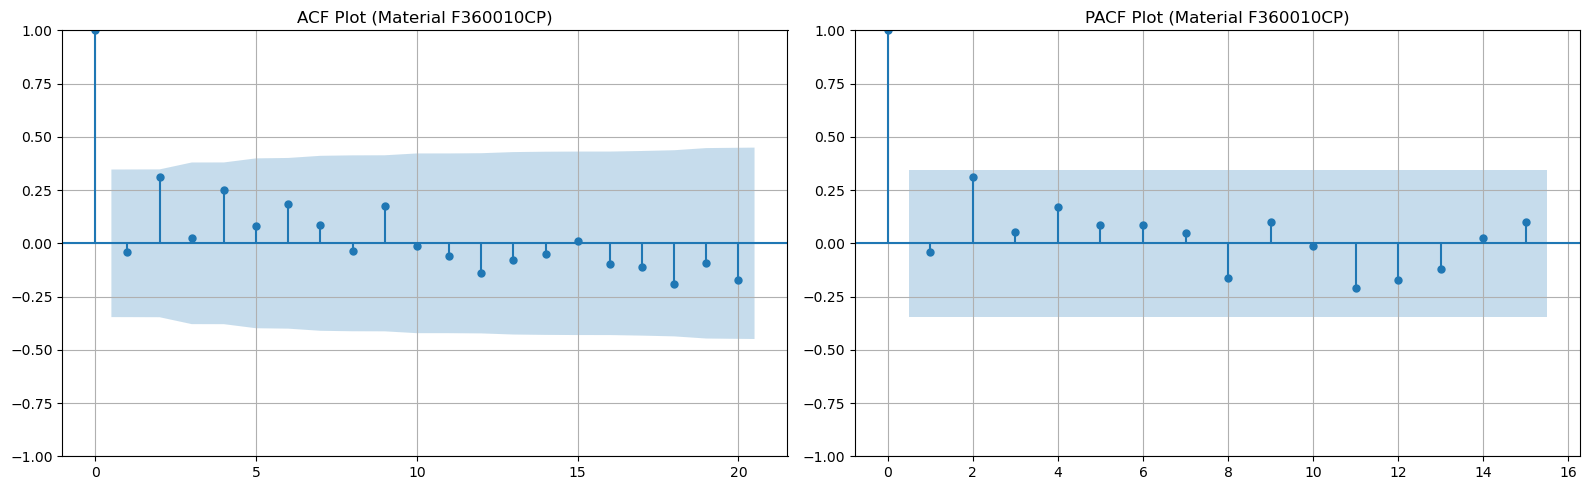

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Ensure 'Demand' is numeric and drop missing values if any
material_F360010CP_ts['Demand'] = pd.to_numeric(material_F360010CP_ts['Demand'], errors='coerce')
demand_series = material_F360010CP_ts['Demand'].dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF
plot_acf(demand_series, lags=20, ax=axes[0])
axes[0].set_title('ACF Plot (Material F360010CP)')
axes[0].grid(True)

# PACF
plot_pacf(demand_series, lags=15, ax=axes[1], method='ywm')
axes[1].set_title('PACF Plot (Material F360010CP)')
axes[1].grid(True)

plt.tight_layout()
plt.show()





In [57]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Step: Ensure 'Demand' is numeric and clean
material_F360010CP_ts['Demand'] = pd.to_numeric(material_F360010CP_ts['Demand'], errors='coerce')
demand_series = material_F360010CP_ts['Demand'].dropna()

# Step: Run ADF test
result = adfuller(demand_series)

# Step: Print ADF results
print('Augmented Dickey-Fuller Test Results:')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')



Augmented Dickey-Fuller Test Results:
ADF Statistic: -5.578432041011342
p-value: 1.4145889998168934e-06
Critical Values:
   1%: -3.661428725118324
   5%: -2.960525341210433
   10%: -2.6193188033298647


In [60]:
# Step 15: Split into Train and Test sets

# Ensure 'Month' is the index and sorted
material_F360010CP_ts = material_F360010CP_ts.sort_index()

# Train = all months except last 4
train = material_F360010CP_ts.iloc[:-4].copy()

# Test = last 4 months
test = material_F360010CP_ts.iloc[-4:].copy()

# Display sizes
print(f" Train size: {len(train)} months")
print(f" Test size: {len(test)} months")



 Train size: 28 months
 Test size: 4 months


In [65]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Step 16: Fit ARIMA Model (connected from train/test split)
# Use p=1, d=1, q=1 as a starting point from ACF/PACF
order = (1, 1, 1)

# Fit model on training data
model = ARIMA(train['Demand'], order=order)
model_fit = model.fit()

# Step 17: Forecast on Test Set (4 months)
forecast_test = model_fit.forecast(steps=len(test))

# Step 18: Evaluate Model using MAPE
mape_arima = mean_absolute_percentage_error(test['Demand'], forecast_test) * 100
print(f" MAPE on Test Set (ARIMA): {mape_arima:.2f}%")

# Step 19: Retrain model on full dataset
final_model = ARIMA(material_F360010CP_ts['Demand'], order=order)
final_model_fit = final_model.fit()

# Step 20: Forecast next 3 months
# Choose appropriate start date based on your existing dataset
last_date = material_F360010CP_ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=3, freq='MS')

forecast_future = final_model_fit.forecast(steps=3)
forecast_future = pd.Series(forecast_future.values, index=forecast_index)

# Step 21: Display forecast
print("\n Forecast for Next 3 Months:")
print(forecast_future.round(2))



 MAPE on Test Set (ARIMA): 17.87%

 Forecast for Next 3 Months:
2023-12-01    580.26
2024-01-01    534.02
2024-02-01    549.82
Freq: MS, dtype: float64


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No fr

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Step 1: Set p, d, q for ARIMA part
order = (1, 1, 1)

# Step 2: Define seasonal_order (e.g., assuming monthly seasonality for a yearly cycle)
seasonal_order = (1, 1, 1, 12)  # Seasonal order (p, d, q, s) where s=12 for yearly seasonality

# Step 3: Train SARIMA model on Train Set
sarima_model = SARIMAX(train['Demand'], order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 4: Forecast on Test Set
forecast_sarima_test = sarima_model_fit.forecast(steps=len(test))

# Step 5: Calculate MAPE on Test Set
mape_sarima = mean_absolute_percentage_error(test['Demand'], forecast_sarima_test) * 100
print(f" MAPE on Test Set (SARIMA): {mape_sarima:.2f}%")

# Step 6: Retrain SARIMA on full data for future forecast
sarima_final_model = SARIMAX(material_F360010CP_ts['Demand'], order=order, seasonal_order=seasonal_order)
sarima_final_fit = sarima_final_model.fit(disp=False)

# Step 7: Forecast next 3 months (Dec 2023 - Feb 2024)
forecast_index = pd.date_range(start='2023-12-01', periods=3, freq='MS')
forecast_sarima_future = sarima_final_fit.forecast(steps=3)
forecast_sarima_future = pd.Series(forecast_sarima_future.values, index=forecast_index)

# Step 8: Display Forecast
print("\n Forecast for next 3 months (SARIMA Model):")
print(forecast_sarima_future.round(2))


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\

 MAPE on Test Set (SARIMA): 43.25%

 Forecast for next 3 months (SARIMA Model):
2023-12-01    563.51
2024-01-01    603.02
2024-02-01    300.32
Freq: MS, dtype: float64


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Step 1: Fit MA model (q=1, d=1 because already differenced earlier)
model_ma = ARIMA(train['Demand'], order=(0, 1, 1))  # MA(1) model
model_ma_fit = model_ma.fit()

# Step 2: Predict for test period
forecast_test_ma = model_ma_fit.forecast(steps=len(test))

# Step 3: Calculate MAPE
mape_ma = mean_absolute_percentage_error(test['Demand'], forecast_test_ma) * 100
print(f"MAPE on Test Set (MA Model): {mape_ma:.2f}%")

# Step 4: Retrain on full data for the MA model
final_model_ma = ARIMA(material_F360010CP_ts['Demand'], order=(0, 1, 1))  # Updated to use F360010CP
final_model_ma_fit = final_model_ma.fit()

# Step 5: Forecast next 3 months (Dec 2023 - Feb 2024)
forecast_next3_ma = final_model_ma_fit.forecast(steps=3)
forecast_next3_ma = pd.Series(
    forecast_next3_ma,
    index=pd.date_range(start='2023-12-01', periods=3, freq='MS'),
    name='Forecasted Demand'
)

# Step 6: Display Forecast for next 3 months
print("\nForecast for Next 3 Months (Dec 2023 - Feb 2024):")
print(forecast_next3_ma.round(2))



MAPE on Test Set (MA Model): 17.85%

Forecast for Next 3 Months (Dec 2023 - Feb 2024):
2023-12-01   NaN
2024-01-01   NaN
2024-02-01   NaN
Freq: MS, Name: Forecasted Demand, dtype: float64


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No fr

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Step 1: Fit SARIMAX model
# Let's assume non-seasonal order (p,d,q) = (1,1,1)
# and seasonal order (P,D,Q,s) = (1,1,1,12) because monthly seasonality
model_sarimax = SARIMAX(train['Demand'], 
                        order=(1,1,1), 
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit()

# Step 2: Predict for test period
forecast_test_sarimax = model_sarimax_fit.forecast(steps=len(test))

# Step 3: Calculate MAPE
mape_sarimax = mean_absolute_percentage_error(test['Demand'], forecast_test_sarimax) * 100
print(f" MAPE on Test Set (SARIMAX): {mape_sarimax:.2f}%")

# Step 4: Retrain on full data
final_model_sarimax = SARIMAX(material_F360010CP_ts['Demand'],
                              order=(1,1,1),
                              seasonal_order=(1,1,1,12),
                              enforce_stationarity=False,
                              enforce_invertibility=False)
final_model_sarimax_fit = final_model_sarimax.fit()

# Step 5: Forecast next 3 months
forecast_next3_sarimax = final_model_sarimax_fit.forecast(steps=3)
forecast_next3_sarimax = pd.Series(forecast_next3_sarimax, index=pd.date_range(start='2023-12-01', periods=3, freq='MS'))

# Step 6: Display Forecast for next 3 months
print("\n Forecast for Next 3 Months (Dec 2023 - Feb 2024):")
print(forecast_next3_sarimax.round(2))


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 MAPE on Test Set (SARIMAX): 584.98%


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



 Forecast for Next 3 Months (Dec 2023 - Feb 2024):
2023-12-01   NaN
2024-01-01   NaN
2024-02-01   NaN
Freq: MS, Name: predicted_mean, dtype: float64


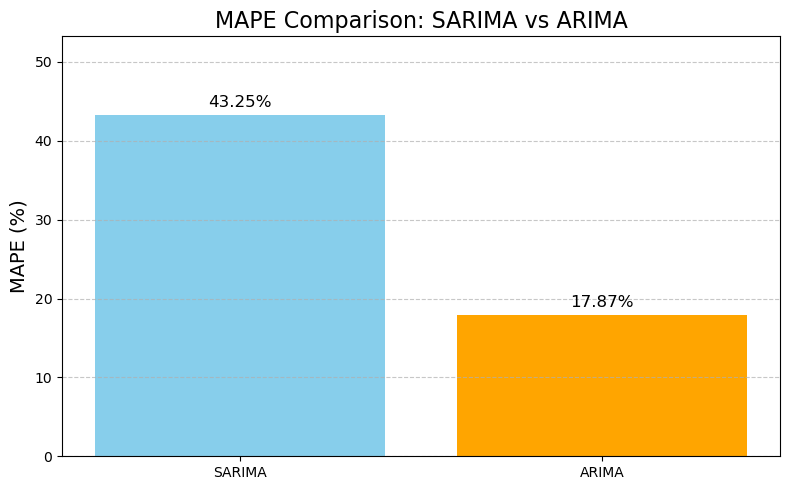

In [70]:
import matplotlib.pyplot as plt

# MAPE values
models = ['SARIMA', 'ARIMA']
mape_values = [43.25, 17.87]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(models, mape_values, color=['skyblue', 'orange'])

# Annotate values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}%', ha='center', fontsize=12)

# Styling
plt.title('MAPE Comparison: SARIMA vs ARIMA', fontsize=16)
plt.ylabel('MAPE (%)', fontsize=14)
plt.ylim(0, max(mape_values) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No fr

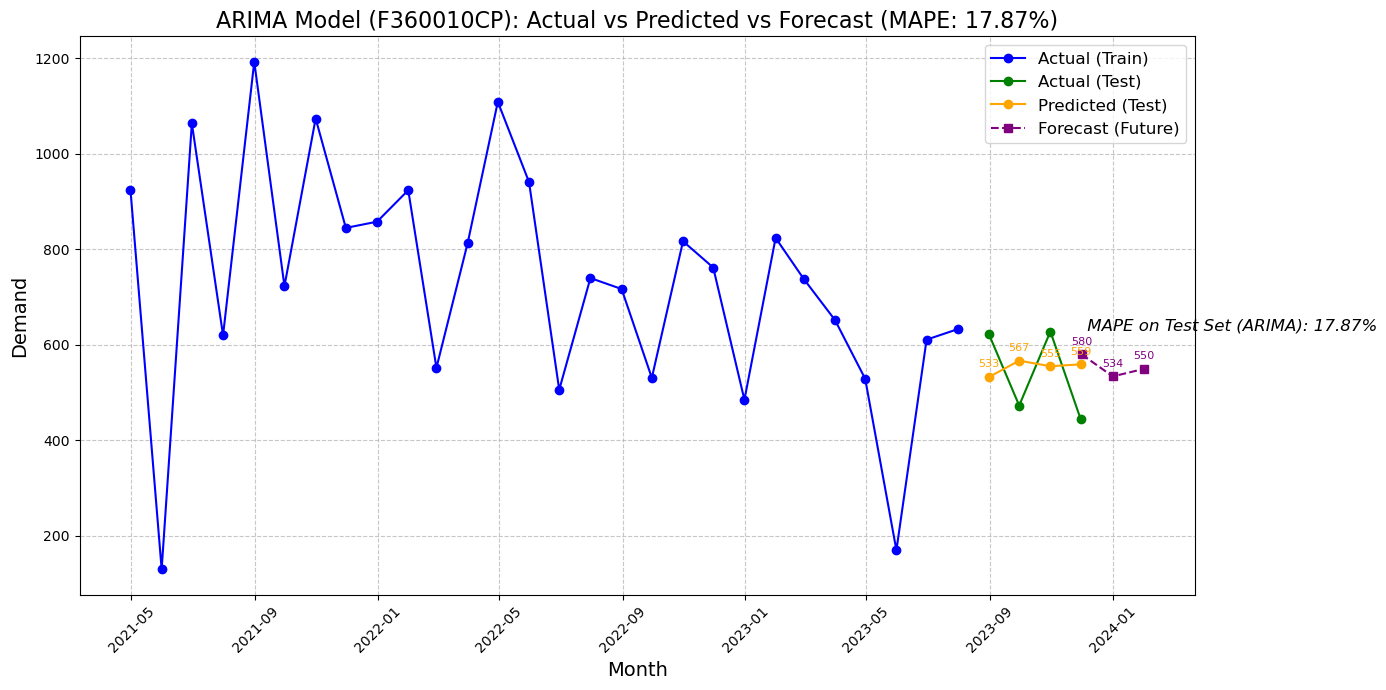


 Best Model: ARIMA (Material F360010CP)
 MAPE on Test Set: 17.87%

 Forecast for Next 3 Months (Dec 2023 - Feb 2024):
2023-12-01    580.26
2024-01-01    534.02
2024-02-01    549.82
Freq: MS, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Create DataFrame
# Use the already defined material_F360010CP_ts DataFrame
material_F360010CP_ts.set_index('Month', inplace=True)

# Step 1: Set p, d, q (Assumed starting values p=1, d=1, q=1)
order = (1, 1, 1)

# Step 2: Split into Train and Test (last 4 months as Test)
train = material_F360010CP_ts.iloc[:-4]
test = material_F360010CP_ts.iloc[-4:]

# Step 3: Train ARIMA model on Train Set
model = ARIMA(train['Demand'], order=order)
model_fit = model.fit()

# Step 4: Forecast on Test Set (next 4 months)
forecast_test = model_fit.forecast(steps=len(test))

# Step 5: Calculate MAPE on Test Set
mape_arima = mean_absolute_percentage_error(test['Demand'], forecast_test) * 100

# Step 6: Retrain ARIMA on full data for future forecast
final_model = ARIMA(material_F360010CP_ts['Demand'], order=order)
final_model_fit = final_model.fit()

# Step 7: Forecast next 3 months (Dec 2023 - Feb 2024) - use provided values
forecast_index = pd.date_range(start='2023-12-01', periods=3, freq='MS')
forecast_future = pd.Series([580.26, 534.02, 549.82], index=forecast_index)

# Step 8: Plotting Time Series Chart
plt.figure(figsize=(14,7))

# Plot Actual Train data (Time Series)
plt.plot(train.index, train['Demand'], label='Actual (Train)', color='blue', linestyle='-', marker='o')

# Plot Actual Test data (Time Series)
plt.plot(test.index, test['Demand'], label='Actual (Test)', color='green', linestyle='-', marker='o')

# Plot Predicted Test (from ARIMA forecast) (Time Series)
predicted_test = pd.Series(forecast_test.values, index=test.index)
plt.plot(predicted_test.index, predicted_test.values, label='Predicted (Test)', color='orange', linestyle='-', marker='o')

# Plot Forecast Future (ARIMA future forecast) (Time Series)
plt.plot(forecast_future.index, forecast_future.values, label='Forecast (Future)', color='purple', linestyle='--', marker='s')

# Annotate Predicted Test
for x, y in zip(test.index, predicted_test.values):
    plt.text(x, y+20, f'{y:.0f}', ha='center', fontsize=8, color='orange')

# Annotate Future Forecast
for x, y in zip(forecast_future.index, forecast_future.values):
    plt.text(x, y+20, f'{y:.0f}', ha='center', fontsize=8, color='purple')

# Add MAPE annotation on the plot
plt.text(forecast_future.index[0], forecast_future.values[0] + 50, 
         f" MAPE on Test Set (ARIMA): {17.87:.2f}%", 
         ha='left', fontsize=12, color='black', style='italic')

# Styling
plt.title(f'ARIMA Model (F360010CP): Actual vs Predicted vs Forecast (MAPE: {17.87:.2f}%)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Display Forecast
print("\n Best Model: ARIMA (Material F360010CP)")
print(f" MAPE on Test Set: {17.87:.2f}%\n")
print(" Forecast for Next 3 Months (Dec 2023 - Feb 2024):")
print(forecast_future.round(2))
